# 1.1 Data Exploration 
## import necessary libraries

In [1]:
# import necessary libraries

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, GridSearchCV

import re
import math
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec, KeyedVectors
from scipy import sparse

from sklearn.decomposition import TruncatedSVD
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import FeatureUnion,Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier,BaggingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn import model_selection,metrics

%matplotlib inline

Using TensorFlow backend.
/Users/luwang/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## loading and merging data
Since the competition is divided into 2 stages, I have to merge `training labels` and `stage1_solution` as final labels **y**; merge `stage2_test,stage2_text` into variable **`test`**, and merge `filtered solution.ID, training_text,training_variants, test_test,test_text` into variable **`train`**.  
I will do both model training and cross validation on `train`. `test` would only be used for leading board submission. 

In [2]:
# loading and merging data

# Merge train.Class and filtered solution to variable y
solution=pd.read_csv('stage1_solution_filtered.csv')
oldtrain= pd.read_csv('training_variants')
oldtrain_txt = pd.read_csv('training_text', sep="\|\|", engine='python', header=None, skiprows=1, names=["ID","Text"])

newtrain_Class=solution.apply(lambda x:[i-1 for i,col in enumerate(solution.columns) if x[col]==1][0],axis=1).values
oldtrain_Class=oldtrain.Class.values-1
y=np.concatenate([oldtrain_Class,newtrain_Class],0)
print oldtrain_Class.shape, newtrain_Class.shape
print y.shape,y

(3321,) (368,)
(3689,) [0 1 1 ..., 5 3 0]


In [3]:
# Merge stage2_test,stage2_text into variable test
test=pd.read_csv('stage2_test_variants.csv')
test_txt = pd.read_csv('stage2_test_text.csv', sep="\|\|", engine='python', header=None, skiprows=1, names=["ID","Text"])
test=pd.merge(test, test_txt, how='left', on='ID').fillna('')
test=test.drop(['ID'],1)
print test.shape,test.columns

(986, 3) Index([u'Gene', u'Variation', u'Text'], dtype='object')


In [4]:
# Merge filtered solution.ID, training_text,training_variants, test_test,test_text into variable train
oldtrain= pd.read_csv('training_variants')
oldtrain_txt = pd.read_csv('training_text', sep="\|\|", engine='python', header=None, skiprows=1, names=["ID","Text"])

oldtest = pd.read_csv('test_variants')
oldtest_txt = pd.read_csv('test_text', sep="\|\|", engine='python', header=None, skiprows=1, names=["ID","Text"])

oldtrain=pd.merge(oldtrain, oldtrain_txt, how='left', on='ID').fillna('')
oldtest=pd.merge(oldtest, oldtest_txt, how='left', on='ID').fillna('')
oldtrain=oldtrain.drop(['Class','ID'],1)
oldtest=oldtest.drop(['ID'],1)

train=pd.concat([oldtrain,oldtest.loc[solution.ID.values,:]],ignore_index=True)
print train.shape,train.columns

(3689, 3) Index([u'Gene', u'Variation', u'Text'], dtype='object')


## Statistics 

In [ ]:
# Create a variable hold information from train,test and y: data_n_label
data=pd.concat([train,test],ignore_index=True)

data_n_label=pd.concat([data,pd.Series([int(i) for i in y],name='label')],1)
data_n_label['ID']=data_n_label.index

# overview of data_n_label
print 'shape of train:',data_n_label.shape
print 'statistics of data_n_label:'
print data_n_label[['Gene','Variation','Text']].describe()
data_n_label.head()

In [ ]:
# overview of test
print 'shape of test:',test.shape
print 'statistics of test:'
print test.describe()
test.head()

## Abnormalities and Characteristics
`Gene` and `Variation` fields are very clean and complete, just like we have explored before. However, `Text` fields has some abnormalities such as **null values**.  
Besides, this 9 classes are quite **imbalanced.**

In [ ]:
# Extemely short Text: null values
empty=[(x,len(x.split())) for x in train['Text'] if len(x.split())<10]
print 'Extemely short Texts:'
empty

In [ ]:
# Extemely long Text: 
xlong=[len(x.split()) for x in train['Text'] if len(x.split())>70000]
print 'Median length:'
np.median([len(x.split()) for x in train['Text']])
print 'Extemely long Texts:'
xlong

In [ ]:
# Weight of Different Classes: imbalanced
fig, ax = plt.subplots()
ax.set_ylabel('Percentage')
ax.set_title('Weight of Different Classes')
fig.set_size_inches(18.5, 10.5)

sns.countplot(x="label", data=data_n_label, palette="Greens_d")


## 1.2  Exploratory Visualization

## Univariate: Gene frequency and the most frequent 25 

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.set_title('Gene Frequency Counts')

sns.countplot(x="Gene", data=data_n_label, palette="Paired")

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.set_title('Top 25 Gene Frequency Counts')
sns.countplot(x="Gene", data=data_n_label, palette="Paired",order=data_n_label.Gene.value_counts().iloc[:25].index)

## Univariate: Variation frequency and the most frequent 10 

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.set_title('Variation Frequency Counts')

sns.countplot(x="Variation", data=data_n_label, palette="Paired")

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.set_title('Top 10 Variation Frequency Counts')
sns.countplot(x="Variation", data=data_n_label, palette="Paired",order=data_n_label.Variation.value_counts().iloc[:10].index)

## Univariate: Text length distribution and an example

In [ ]:
# Text
fig, ax= plt.subplots()
fig.set_size_inches(18.5, 10.5)

ax.set_ylabel('Number of Words')
ax.set_title('Number of Words Distribution for train.Text')
sns.set(font_scale=1.4)
sns.distplot([len(x.split()) for x in data_n_label['Text']])
sns.plt.show()


# Create a histogram by providing the bin edges (unequally spaced).
# bins = [100, 150, 180, 195, 205, 220, 250, 300]

print 'An example of Text: data_n_label.loc[0]'
print data_n_label.loc[0]
print
print 'number of characters in Text of entry 0:', len(data_n_label.loc[0,'Text'])
print
print 'number of words in Text of entry 0:', len(data_n_label.loc[0,'Text'].split())
print 
print 'Content of this Text:'
print data_n_label.loc[0,'Text']


## Bivariate: 8 Top frequent genes for each class

In [ ]:
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(18.5,10.5))
for i in range(3):
    for j in range(3):
        gene_count_grp = data_n_label[data_n_label["label"]==(i*3+j)].groupby('Gene')["ID"].count().reset_index()
        sorted_gene_group = gene_count_grp.sort_values('ID', ascending=False)
        sorted_gene_group_top_8 = sorted_gene_group[:8]
        sns.barplot(x="Gene", y="ID", data=sorted_gene_group_top_8, ax=axs[i][j])

## Bivariate: 4 top frequent variations for each class

In [ ]:
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(18.5,10.5))
for i in range(3):
    for j in range(3):
        var_count_grp = data_n_label[data_n_label["label"]==(i*3+j)].groupby('Variation')["ID"].count().reset_index()
        sorted_var_group = var_count_grp.sort_values('ID', ascending=False)
        sorted_var_group_top_4 = sorted_var_group[:4]
        sns.barplot(x="Variation", y="ID", data=sorted_var_group_top_4, ax=axs[i][j],palette="husl")

## Bivariate: text lengh versus class  
Since there are too few variables, the numerical variables used are created from original catagorical variables by code below ( **belong to feature engineering part**):  

In [ ]:
# Concatate test and train into: data
data=pd.concat([train,test],ignore_index=True)
print "Before:",data.shape, data.columns

# feature engineering: 'Gene_txt', 'Variation_txt', 'txt'
data['Gene_txt']=data.apply(lambda x: " ".join(re.findall(r'([^.]*%s[^.]*\.)'%(x['Gene']),x['Text'],flags=0)),axis=1)
data['Variation_txt']=data.apply(lambda x: " ".join(re.findall(r'([^.]*%s[^.]*\.)'%(x['Variation']),x['Text'],flags=0)),axis=1)
data['txt']=data.apply(lambda x: x['Gene_txt']+x['Variation_txt'],axis=1)
emp_txt=[]
for i in range(len(data['txt'])):
    if len(data['txt'][i])==0:
        data['txt'][i]=data['Text'][i]
        emp_txt.append(i)
print 'how many empty txt area replaced with Text:',len(emp_txt)
print "After extraction:",data.shape, data.columns

# lbl and length encoding: 2x3+4x2=14 more features   
for c in data:
    if data[c].dtype == 'object':
        if c in ['Gene','Variation']:
            lbl = LabelEncoder()
            data[c+'_lbl_enc'] = lbl.fit_transform(data[c].values)
            data[c+'_len'] = data[c].map(lambda x: len(str(x)))
            data[c+'_words'] = data[c].map(lambda x: len(str(x).split(' ')))
        elif c not in ['Text','Gene_txt','Variation_txt','txt']:
            lbl = LabelEncoder()
            data[c] = lbl.fit_transform(data[c].values)
        if c in ['Text','Gene_txt','Variation_txt','txt']:
            data[c+'_len'] = data[c].map(lambda x: len(str(x)))
            data[c+'_words'] = data[c].map(lambda x: len(str(x).split(' ')))
print "After lbl and length encoding:",data.shape, data.columns

data_n_label=pd.concat([data,pd.Series([int(i) for i in y],name='label')],1)
data_n_label['ID']=data_n_label.index

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
sns.violinplot(x=u'label', y=u'Text_len', data=data_n_label,
               split=True, inner="stick", palette="Set3")

## Pairplot: Text and Word Length Correlation  


In [ ]:
sns.pairplot(data_n_label[[u'Text_len',u'Text_words',
                           u'Gene_txt_len',u'Gene_txt_words',   
                           u'Variation_txt_len', u'Variation_txt_words',
                           u'txt_len',u'txt_words']])

# 2.1 Data preprocessing
Including feature engineering and encoding.  

## Feature engineering: encoding for `Text`

In [5]:
# Concatate test and train into: data
data=pd.concat([train,test],ignore_index=True)
print "Before:",data.shape, data.columns

# feature engineering: 'Gene_txt', 'Variation_txt', 'txt'
data['Gene_txt']=data.apply(lambda x: " ".join(re.findall(r'([^.]*%s[^.]*\.)'%(x['Gene']),x['Text'],flags=0)),axis=1)
data['Variation_txt']=data.apply(lambda x: " ".join(re.findall(r'([^.]*%s[^.]*\.)'%(x['Variation']),x['Text'],flags=0)),axis=1)
data['txt']=data.apply(lambda x: x['Gene_txt']+x['Variation_txt'],axis=1)
emp_txt=[]
for i in range(len(data['txt'])):
    if len(data['txt'][i])==0:
        data['txt'][i]=data['Text'][i]
        emp_txt.append(i)
print 'how many empty txt area replaced with Text:',len(emp_txt)
print "After extraction:",data.shape, data.columns

# lbl and length encoding: 2x3+4x2=14 more features   
for c in data:
    if data[c].dtype == 'object':
        if c in ['Gene','Variation']:
            lbl = LabelEncoder()
            data[c+'_lbl_enc'] = lbl.fit_transform(data[c].values)
            data[c+'_len'] = data[c].map(lambda x: len(str(x)))
            data[c+'_words'] = data[c].map(lambda x: len(str(x).split(' ')))
        elif c not in ['Text','Gene_txt','Variation_txt','txt']:
            lbl = LabelEncoder()
            data[c] = lbl.fit_transform(data[c].values)
        if c in ['Text','Gene_txt','Variation_txt','txt']:
            data[c+'_len'] = data[c].map(lambda x: len(str(x)))
            data[c+'_words'] = data[c].map(lambda x: len(str(x).split(' ')))
print "After lbl and length encoding:",data.shape, data.columns

Before: (4675, 3) Index([u'Gene', u'Variation', u'Text'], dtype='object')
how many empty txt area replaced with Text: 172
After extraction: (4675, 6) Index([u'Gene', u'Variation', u'Text', u'Gene_txt', u'Variation_txt', u'txt'], dtype='object')
After lbl and length encoding: (4675, 20) Index([u'Gene', u'Variation', u'Text', u'Gene_txt', u'Variation_txt', u'txt',
       u'Gene_lbl_enc', u'Gene_len', u'Gene_words', u'Variation_lbl_enc',
       u'Variation_len', u'Variation_words', u'Text_len', u'Text_words',
       u'Gene_txt_len', u'Gene_txt_words', u'Variation_txt_len',
       u'Variation_txt_words', u'txt_len', u'txt_words'],
      dtype='object')


## Feature engineering: encoding for `Gene` and `Variation`

In [6]:
# one-hot encoding of Gene
unique, counts = np.unique(data['Gene'], return_counts=True)
print 'Unique genes :',len(unique),'Total counts:',sum(counts)
count_uni=sorted([(counts[i],unique[i]) for i in range(len(unique))])[::-1]
# print count_uni
data['Gene_oht_enc']=[[i] for i in pd.get_dummies(data['Gene']).values]

# one-hot encoding of Variation
data['Type']=np.nan
assigned=0
types=['*','fusion','delins','dup','fs','del','ins','trunc','amp',
      'splice','promoter','methyl','exon','overexpression','dna binding,'
      'methyl','egfr','copy number loss','wildtype']
for i in range(data.shape[0]):    
    mut=data['Variation'][i]
    find=re.findall(r'[A-Z]\d+[A-Z]',mut,flags=0)
    if len(find)==1 and find[0]==mut:
        data['Type'][i]='snp'
        assigned+=1
    else:
        if len(mut.split('*'))>1 and len(mut.split('*')[-1])==0:
            data['Type'][i]='null'
            assigned+=1
        else:
            for mut_type in types:
                if mut_type in mut.lower() :
                    data['Type'][i]=mut_type
                    assigned+=1
                    break
    if pd.isnull(data['Type'][i]):
#         print i,data['Variation'][i]
        data['Type'][i]='others' 
        
print data.shape[0]-assigned
# mannul correction
data['Type'][350]='silencing'
data['Type'][480]='dna binding'
data['Type'][[3389,3947]]='snp'
data['Type'][3897,4008,4165,4242,4365]='stop2met'
unique, counts = np.unique(data['Type'], return_counts=True)
print 'Unique variation types :',len(unique),'Total counts:',sum(counts)
count_uni=sorted([(counts[i],unique[i]) for i in range(len(unique))])[::-1]
# print count_uni
data['Variation_oht_enc']=[[x] for x in pd.get_dummies(data['Type']).values]  
data=data.drop(['Type'],1)
print 'After one-hot encoding',data.shape, data.columns



Unique genes : 401 Total counts: 4675


/Users/luwang/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/luwang/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/luwang/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/luwang/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:18: Se

19


/Users/luwang/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/luwang/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/luwang/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Unique variation types : 23 Total counts: 4675
After one-hot encoding (4675, 22) Index([u'Gene', u'Variation', u'Text', u'Gene_txt', u'Variation_txt', u'txt',
       u'Gene_lbl_enc', u'Gene_len', u'Gene_words', u'Variation_lbl_enc',
       u'Variation_len', u'Variation_words', u'Text_len', u'Text_words',
       u'Gene_txt_len', u'Gene_txt_words', u'Variation_txt_len',
       u'Variation_txt_words', u'txt_len', u'txt_words', u'Gene_oht_enc',
       u'Variation_oht_enc'],
      dtype='object')


/Users/luwang/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [7]:
# Separate test,train after preprocessing
train=data[:3689]
test=data[3689:].reset_index(drop=True)
print train.shape, test.shape

(3689, 22) (986, 22)


# 2.2 Implementation: pipeline


In [12]:
#12 features are saved, Variation_words and Gene_words are dropped.
#the 12 features are: 2 x lbl_enc,4xtxt_len,4xtxt_words，Gene／Variation_len
class cust_regression_vals(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self
    def transform(self, x):
        x=x[[u'Gene_lbl_enc', u'Gene_len', u'Variation_lbl_enc',u'Variation_len',u'Text_len', u'Text_words',u'Gene_txt_len', u'Gene_txt_words', u'Variation_txt_len',u'Variation_txt_words', u'txt_len', u'txt_words']].values
        return x
        
#one-hot-encoding on Gene
class Geneoht_transformer(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self
    def transform(self, x):
        x = np.array([np.array(i[0]) for i in x['Gene_oht_enc'].values])
        return x
    
#one-hot-encoding one Variation   
class Variationoht_transformer(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self
    def transform(self, x):
        x = np.array([np.array(i[0]) for i in x['Variation_oht_enc'].values])
        return x

    
class cust_txt_col(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
    def fit(self, x, y=None):
        return self
    def transform(self, x):
        return x[self.key].apply(str)

# pi11 CountVectorizer on Gene 
vec1=CountVectorizer(analyzer=u'char', ngram_range=(1, 8))
svd1=TruncatedSVD(n_components=15, n_iter=5, random_state=12)
pi11=Pipeline([
    ('Gene', cust_txt_col('Gene')), 
    ('count_Gene', vec1), 
    ('tsvd1', svd1)
])
#pi12 CountVectorizer on Variation
pi12=Pipeline([
    ('Variation', cust_txt_col('Variation')),
    ('count_Variation', vec1), 
    ('tsvd1',svd1)
])

#pi21 Gene_oht 
svd21=TruncatedSVD(n_components=120, n_iter=5, random_state=12)
pi21=Pipeline([
    ('Gene_oht', Geneoht_transformer()), 
    ('tsvd21', svd21)
])
#pi22 Variation_oht 
svd22=TruncatedSVD(n_components=5, n_iter=5, random_state=12)
pi22=Pipeline([
    ('Variation_oht', Variationoht_transformer()), 
    ('tsvd22', svd22)
])


#pi3 tfidf 
svd3=TruncatedSVD(n_components=200, n_iter=1, random_state=12)
vec3=TfidfVectorizer(
	 max_features=5000,strip_accents='unicode',lowercase =True,
	analyzer='word', token_pattern=r'\w+', ngram_range=(1, 2), use_idf=True, 
	smooth_idf=True, sublinear_tf=True, stop_words = 'english'
)
# txt
pi31=Pipeline([
    ('cust_txt_col',cust_txt_col('txt')),
    ('tfidf', vec3), 
    ('tsvd3', svd3)
    
])
# Text
pi32=Pipeline([
    ('cust_txt_col',cust_txt_col('Text')),
    ('tfidf', vec3), 
    ('tsvd3', svd3)
    
])


#turn on and off each pipeline to do feature selection and reduction
fp = Pipeline([('union', FeatureUnion(n_jobs = -1,
                                      transformer_list = [
                                          ('standard', cust_regression_vals()),
                                          ('pi11', pi11),
                                          ('pi12',pi12),
                                          ('Gene_oht', pi21),
                                          ('Variation_oht',pi22),
                                          ('tfidf1',pi31),
#                                           ('tfidf2',pi32)
                                      ])
               )])
X=fp.fit_transform(train)
X_test=fp.fit_transform(test)
print X.shape
print X_test.shape

(3689, 367)
(986, 367)


## Testing the effect of various inputs by Logistic Regression

**Results**  

Groups of features|numerical features | CountVectorizer on Gene | CountVectorizer on Variation | one-hot-encoding on Gene| one-hot-encoding on Variation | tf-idf on Text | tf-idf on txt 
---|---|---|---|---|---|---
Original dimention no. | 14 | NA | NA | 401 | 23 | 5000 | 5000
Need reduction? | Yes | Yes | Yes | Yes | Yes | Yes | Yes
Dropped features| Variation_words, Gene_words | anonymous | anonymous | anonymous | anonymous | anonymous | anonymous
Best dimention no. | 12 | 15 | 15 | 120 | 5 |  100 |200 
Logloss based on only this group | 0.9978 | 1.1277 | 1.5849 | 1.1223 | 1.6790 | 0.9231 |0.8717 

In [26]:
# Testing the effect of various input by Logistic Regression

n_folds = 5

kf = StratifiedKFold(n_splits=n_folds, random_state=3, shuffle=True)
folds=list(kf.split(X, y))

preds=np.zeros((X_test.shape[0],9))
p_valids=np.zeros((X.shape[0],9))

score=[]
for i,(train_index, test_index) in enumerate(folds):
    print '****Fold',i
    X_train, X_valid    = X[train_index], X[test_index]
    y_train, y_valid    = y[train_index],   y[test_index]
    
    clf = LogisticRegression(C=3,solver='newton-cg',multi_class='ovr',penalty='l2',random_state=3)
    clf.fit(X_train, y_train)
    p_valid=clf.predict_proba(X_valid)
    score.append(metrics .log_loss(y_valid, p_valid))
    print metrics.log_loss(y_valid, p_valid)

# print 'elapsed time:', time.time()-t0
# print 'CPU time:', time.clock()-c0
print np.mean(score)

****Fold 0
1.05898379704
****Fold 1
1.07996285243
****Fold 2
1.05543674071
****Fold 3
1.06740355461
****Fold 4
1.00512749103
1.05338288716


## The improved Logistic Regression

In [27]:
# Testing the effect of various input by Logistic Regression
n_folds = 5

kf = StratifiedKFold(n_splits=n_folds, random_state=3, shuffle=True)
folds=list(kf.split(X, y))

preds=np.zeros((X_test.shape[0],9))
p_valids=np.zeros((X.shape[0],9))

score=[]
for i,(train_index, test_index) in enumerate(folds):
    print '****Fold',i
    X_train, X_valid    = X[train_index], X[test_index]
    y_train, y_valid    = y[train_index],   y[test_index]
    
    clf = LogisticRegression(C=3,solver='liblinear',multi_class='ovr',penalty='l1',random_state=3)
    clf.fit(X_train, y_train)
    p_valid=clf.predict_proba(X_valid)
    score.append(metrics .log_loss(y_valid, p_valid))
    print metrics.log_loss(y_valid, p_valid)

# print 'elapsed time:', time.time()-t0
# print 'CPU time:', time.clock()-c0
print np.mean(score)


****Fold 0
0.933176923042
****Fold 1
0.992718657702
****Fold 2
0.979749365163
****Fold 3
0.953613910305
****Fold 4
0.925277701297
0.956907311502


## Top level generalizer: XGB without ensembling

In [13]:
n_folds = 5

kf = StratifiedKFold(n_splits=n_folds, random_state=3, shuffle=True)
folds=list(kf.split(X, y))

preds=np.zeros((X_test.shape[0],9))
p_valids=np.zeros((X.shape[0],9))

loglossCV=[]
for i,(train_index, test_index) in enumerate(folds):
    print '****Fold',i
    X_train, X_valid    = X[train_index], X[test_index]
    y_train, y_valid    = y[train_index],   y[test_index]
    params = {
        'eta': 0.02,
        'max_depth': 4,
        'objective': 'multi:softprob',#softmax multiclass regression, return probs
        'eval_metric': 'mlogloss',
        'subsample':0.85,
        'num_class': 9,
        'seed': i,
        'silent': True
    }

    watchlist = [(xgb.DMatrix(X_train, y_train), 'train'), (xgb.DMatrix(X_valid, y_valid), 'valid')]
    model = xgb.train(params, xgb.DMatrix(X_train, y_train), 1000,  watchlist, verbose_eval=50, early_stopping_rounds=100)
    p_valid=model.predict(xgb.DMatrix(X_valid), ntree_limit=model.best_ntree_limit)
    p_valids[test_index]=p_valid 
    
    score=metrics.log_loss(y_valid,p_valid, labels = list(range(9)))  
    print score
    loglossCV.append(score)

    pred = model.predict(xgb.DMatrix(X_test), ntree_limit=model.best_ntree_limit)    
    preds += pred

print 'Work finished.'
print 'Local CV:',metrics.log_loss(y,p_valids)
print 'Mean of loglossCV',np.mean(loglossCV)
print 'STD of loglossCV',np.std(loglossCV)


preds /= n_folds
submission = pd.DataFrame(preds, columns=['class'+str(c+1) for c in range(9)])
submission['ID'] = range(1,test.shape[0]+1)
submission.to_csv('meta-xgb.csv', index=False)

# 1 Local CV: 0.820157304556
# 3 Local CV: 0.827708644539 STD: 0.0182124720275
# 26 Local CV: 0.828352173123 STD: 0.0553800842787(盖棺定论了，random_state=3最好)

****Fold 0
[0]	train-mlogloss:2.16159	valid-mlogloss:2.1637
Multiple eval metrics have been passed: 'valid-mlogloss' will be used for early stopping.

Will train until valid-mlogloss hasn't improved in 100 rounds.
[50]	train-mlogloss:1.28385	valid-mlogloss:1.41156
[100]	train-mlogloss:0.942553	valid-mlogloss:1.14815
[150]	train-mlogloss:0.754868	valid-mlogloss:1.01677
[200]	train-mlogloss:0.6307	valid-mlogloss:0.941853
[250]	train-mlogloss:0.534851	valid-mlogloss:0.895044
[300]	train-mlogloss:0.458315	valid-mlogloss:0.865278
[350]	train-mlogloss:0.395788	valid-mlogloss:0.846036
[400]	train-mlogloss:0.345455	valid-mlogloss:0.834497
[450]	train-mlogloss:0.30254	valid-mlogloss:0.825142
[500]	train-mlogloss:0.265953	valid-mlogloss:0.820435
[550]	train-mlogloss:0.235673	valid-mlogloss:0.817428
[600]	train-mlogloss:0.209043	valid-mlogloss:0.815813
[650]	train-mlogloss:0.186138	valid-mlogloss:0.815236
[700]	train-mlogloss:0.166297	valid-mlogloss:0.816336
[750]	train-mlogloss:0.1492	valid-mlog

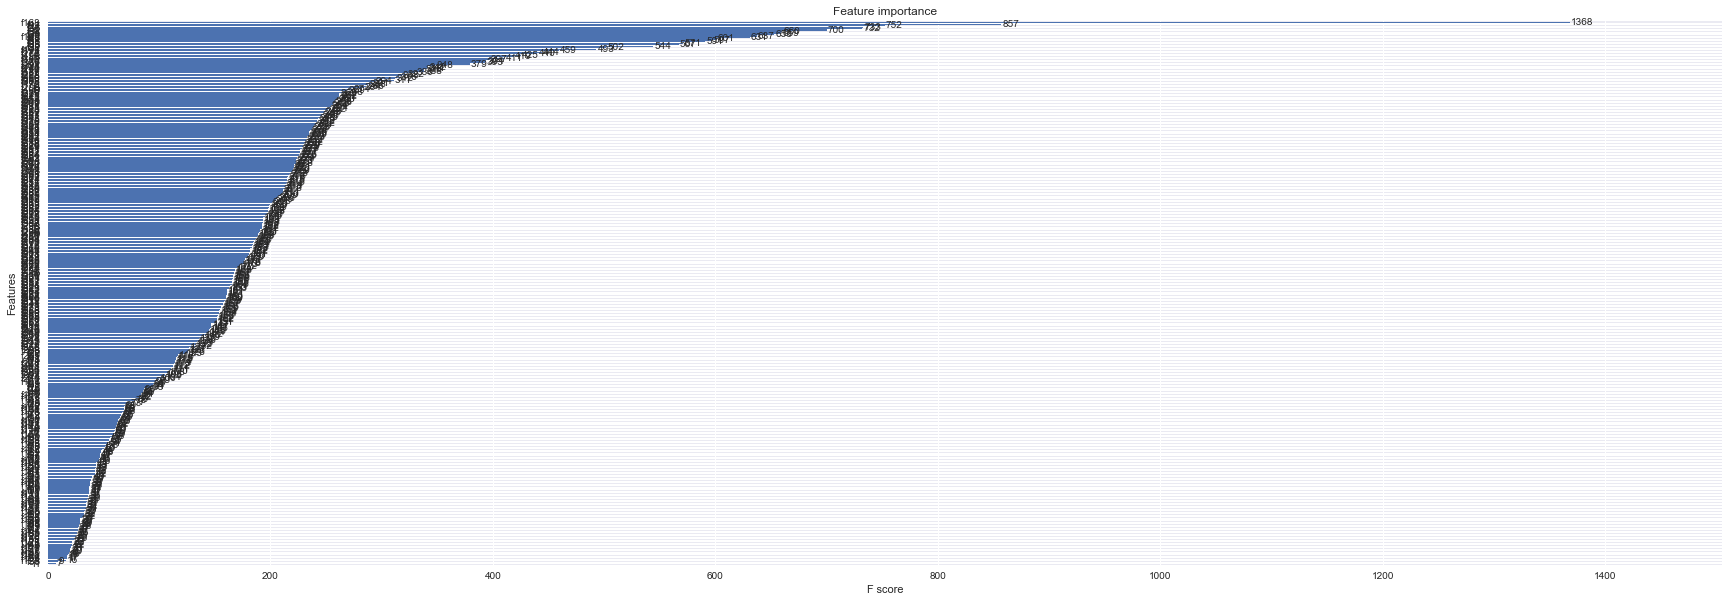

In [14]:
fig, ax = plt.subplots(figsize=(30,10))
xgb.plot_importance(model, height=0.8, ax=ax)
plt.show()    

## Find base models for ensemble   

**base models:**  

Algorithm | LR(penalty=1) | LR(penalty=2) | GB | LDA | KNN
---|---|---|---|---|---
 Best Scores| 0.9124 | 1.05334 | 0.8566 | 1.4490 | 5.8718

In [39]:
# base models generator and filter

seed=3

kf = StratifiedKFold(n_splits=5, random_state=3, shuffle=True)
folds=list(kf.split(X, y))
X_train,y_train=X[folds[0][0]],y[folds[0][0]]
X_valid,y_valid=X[folds[0][1]],y[folds[0][1]]

lr1 = LogisticRegression(C=3,solver='liblinear',multi_class='ovr',penalty='l1',random_state=seed)
gbc=GradientBoostingClassifier(max_features=0.8)
lda=LinearDiscriminantAnalysis()
knn=KNeighborsClassifier(n_neighbors=9)
lr2 = LogisticRegression(C=3,solver='newton-cg',multi_class='ovr',penalty='l2',random_state=seed)


clfs=[lr1,gbc,lda,knn,lr2]
names=['LR1','GB','LDA','KNN','LR2']
base_models=zip(names,clfs)

# cv, pick model with better performance
preds=[]
for name,clf in base_models[:]:
    clf.fit(X_train,y_train)
    p_valid=clf.predict_proba(X_valid)
    print name,':',metrics.log_loss(y_valid,p_valid)
    pred=clf.predict_proba(X_test)
    preds.append(pred)


LR1 : 0.933176923042
GB : 0.901245800912
LDA : 1.37353507387
KNN : 6.42804497154
LR2 : 1.05898379704


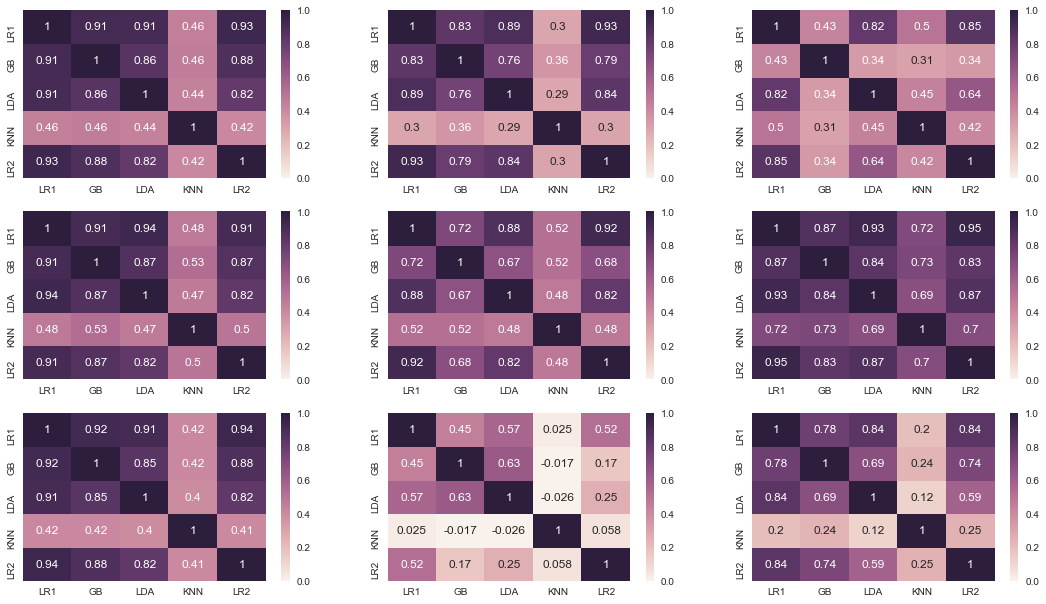

In [40]:
# check corrleation, pick more diverse model
frame = np.zeros((X_valid.shape[0], len(names)*9))
frame_trans=np.zeros((9,X_valid.shape[0],len(names)))
for k in range(len(names)):
        clfs[k].fit(X_train,y_train)
        p_valid=clfs[k].predict_proba(X_valid)
        frame[:,k*9:(k+1)*9]=p_valid        
for i in range(9):
        frame_trans[i]=frame[:,[x for x in range(len(names)*9) if x%9==i]]
            
sns.set(style="white")
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(18.5,10.5))
for i in range(3):
    for j in range(3):
        class_pred=pd.DataFrame(frame_trans[(i*3)+j],columns=names)        
        corr=class_pred.corr()
        sns.heatmap(corr,vmin=0, vmax=1,annot=True,ax=axs[i][j])      

## Final Model I: fair performance with high variance 

In [37]:
seed=3

lr1 = LogisticRegression(C=3,solver='liblinear',multi_class='ovr',penalty='l1',random_state=seed)
gbc=GradientBoostingClassifier(max_features=0.8)
xgbc=xgb

lda=LinearDiscriminantAnalysis()
knn=KNeighborsClassifier(n_neighbors=9)
lr2 = LogisticRegression(C=3,solver='newton-cg',multi_class='ovr',penalty='l2',random_state=seed)


clfs=[lr1,gbc,xgbc,
      lda,knn,lr2]
names=['LR1','GB','XGB',
       'LDA','KNN','LR2']

base_models=zip(names,clfs)

class Ensemble(object):
    def __init__(self, n_folds, stacker, base_models):
        self.n_folds = n_folds
        self.stacker = stacker
        self.base_models = base_models
        
    def fit_predict(self, X, y, T):
        X = np.array(X)
        y = np.array(y)
        T = np.array(T)
        
        kfold=StratifiedKFold(n_splits=self.n_folds, shuffle=True, random_state=3)
        folds = list(kfold.split(X,y))
        
        #Create S_test(for predicting), S_train(for fitting)
        S_test = np.zeros((T.shape[0], 9*len(self.base_models)))
        S_train=np.zeros((X.shape[0], 9*len(self.base_models)))
        for i, (name, clf) in enumerate(self.base_models):
            
            S_test_i = np.zeros((T.shape[0], 9))
            print 'The currently predicting clf is:',i+1,names[i]
    
            for j, (train_idx, test_idx) in enumerate(folds):
                print 'fold',j+1
                X_train = X[train_idx]
                y_train = y[train_idx]
                X_holdout = X[test_idx]
                y_holdout =y[test_idx]
                
                if name=='XGB':
                    params = {
                        'eta': 0.02,
                        'max_depth': 4,
                        'objective': 'multi:softprob',
                        'eval_metric': 'mlogloss',
                        'subsample':0.85,
                        'num_class': 9,
                        'seed': i,
                        'silent': True
                    }
                    
                    watchlist = [(xgb.DMatrix(X_train, y_train), 'train'), (xgb.DMatrix(X_holdout, y_holdout), 'valid')]
                    bst=xgb.train(params, xgb.DMatrix(X_train, y_train), 1000, watchlist,verbose_eval=50, early_stopping_rounds=100)
                    ho_pred=bst.predict(xgb.DMatrix(X_holdout), ntree_limit=bst.best_ntree_limit)
                    y_pred=bst.predict(xgb.DMatrix(T), ntree_limit=bst.best_ntree_limit)
                else:        
                    clf.fit(X_train, y_train)
                    ho_pred = clf.predict_proba(X_holdout)
                    y_pred=clf.predict_proba(T)
                    print metrics.log_loss(y_holdout,ho_pred)
                    
                S_train[test_idx, 9*i:9*(i+1)] = ho_pred               
                S_test_i+= y_pred                                
                S_test_i /=self.n_folds
                S_test[:,9*i:9*(i+1)]=S_test_i
            print name,'Local CV:', metrics.log_loss(y,S_train[:,9*i:9*(i+1)])
        print 'start stacking...'
        # generalize base models   
        for i, (train_idx, test_idx) in enumerate(folds):
            y_cvvalid,X_cvvalid=y[folds[i][1]],S_train[folds[i][1]]
            y_cvtrain,X_cvtrain=y[folds[i][0]],S_train[folds[i][0]]
            self.stacker.fit(X_cvtrain, y_cvtrain)       
            p_valid=self.stacker.predict_proba(X_cvvalid)
            print 'Fold',i,'CV:',metrics.log_loss(y_cvvalid,p_valid)            
            
        p_pred = self.stacker.predict_proba(S_test)
        return S_test,S_train,p_pred


ensem=Ensemble(n_folds=5,stacker=lr1,base_models=base_models)
S_test,S_train,y_pred=ensem.fit_predict(X,y,X_test)

The currently predicting clf is: 1 LR1
fold 1
0.933176923042
fold 2
0.992718657702
fold 3
0.979749365163
fold 4
0.953613910305
fold 5
0.925277701297
LR1 Local CV: 0.956925345479
The currently predicting clf is: 2 GB
fold 1
0.943406400731
fold 2
0.913165509401
fold 3
0.891165859857
fold 4
0.915257889356
fold 5
0.85651855678
GB Local CV: 0.904007004817
The currently predicting clf is: 3 XGB
fold 1
[0]	train-mlogloss:2.16123	valid-mlogloss:2.16609
Multiple eval metrics have been passed: 'valid-mlogloss' will be used for early stopping.

Will train until valid-mlogloss hasn't improved in 100 rounds.
[50]	train-mlogloss:1.28329	valid-mlogloss:1.41467
[100]	train-mlogloss:0.941718	valid-mlogloss:1.1516
[150]	train-mlogloss:0.754529	valid-mlogloss:1.02287
[200]	train-mlogloss:0.627669	valid-mlogloss:0.948399
[250]	train-mlogloss:0.531983	valid-mlogloss:0.903334
[300]	train-mlogloss:0.455585	valid-mlogloss:0.873452
[350]	train-mlogloss:0.394127	valid-mlogloss:0.854417
[400]	train-mlogloss:0.34

In [36]:
# selecting input 
cls=range(S_train.shape[1])
print len(cls)

# XGB
loglossCV=[]
preds=np.zeros((X_test.shape[0],9))
p_valids=np.zeros((X.shape[0],9))

for i,(train_index, test_index) in enumerate(folds):
    print '****Fold',i
    M_train, M_valid    = S_train[:,cls][train_index], S_train[:,cls][test_index]
    y_train, y_valid    = y[train_index],   y[test_index]
    params = {
        'eta': 0.02,
        'max_depth': 4,
        'objective': 'multi:softprob',#softmax multiclass regression, return probs
        'eval_metric': 'mlogloss',
        'subsample':0.85,
        'num_class': 9,
        'seed': i,
        'silent': True
    }

    watchlist = [(xgb.DMatrix(M_train, y_train), 'train'), (xgb.DMatrix(M_valid, y_valid), 'valid')]
    model = xgb.train(params, xgb.DMatrix(M_train, y_train), 1000,  watchlist, verbose_eval=50, early_stopping_rounds=100)
    p_valid=model.predict(xgb.DMatrix(M_valid), ntree_limit=model.best_ntree_limit)
    score1 = metrics.log_loss(y_valid,p_valid, labels = list(range(9)))    
    p_valids[test_index]=p_valid    
    print(score1)
    loglossCV.append(score1)
    pred = model.predict(xgb.DMatrix(S_test[:,cls]), ntree_limit=model.best_ntree_limit)    
    preds += pred

print 'Work finished.'
print 'Local CV:',metrics.log_loss(y,p_valids)
print 'Mean of loglossCV',np.mean(loglossCV)
print 'STD of loglossCV',np.std(loglossCV)


# preds /= n_folds
# submission = pd.DataFrame(preds, columns=['class'+str(c+1) for c in range(9)])
# submission['ID'] = range(1,test.shape[0]+1)
# submission.to_csv('meta-xgb.csv', index=False)

****Fold 0
[0]	train-mlogloss:2.14579	valid-mlogloss:2.15004
Multiple eval metrics have been passed: 'valid-mlogloss' will be used for early stopping.

Will train until valid-mlogloss hasn't improved in 100 rounds.
[50]	train-mlogloss:1.07728	valid-mlogloss:1.21606
[100]	train-mlogloss:0.753011	valid-mlogloss:0.968539
[150]	train-mlogloss:0.603235	valid-mlogloss:0.882681
[200]	train-mlogloss:0.516488	valid-mlogloss:0.848613
[250]	train-mlogloss:0.457301	valid-mlogloss:0.836992
[300]	train-mlogloss:0.409551	valid-mlogloss:0.83585
[350]	train-mlogloss:0.365389	valid-mlogloss:0.838078
Stopping. Best iteration:
[287]	train-mlogloss:0.421333	valid-mlogloss:0.835499

0.835499069126
****Fold 1
[0]	train-mlogloss:2.14585	valid-mlogloss:2.15017
Multiple eval metrics have been passed: 'valid-mlogloss' will be used for early stopping.

Will train until valid-mlogloss hasn't improved in 100 rounds.
[50]	train-mlogloss:1.07644	valid-mlogloss:1.20744
[100]	train-mlogloss:0.75191	valid-mlogloss:0.962

In [ ]:
preds /= n_folds
submission = pd.DataFrame(preds, columns=['class'+str(c+1) for c in range(9)])
submission['ID'] = range(1,test.shape[0]+1)
submission.to_csv('meta-xgb_cv08053295std0055.csv', index=False)

## Final Model II: excellent performance with low variance 

In [ ]:
seed=3
lr1 = LogisticRegression(C=3,solver='liblinear',multi_class='ovr',penalty='l1',random_state=seed)#0.9+
lr11 = LogisticRegression(C=3,solver='liblinear',multi_class='ovr',penalty='l2',random_state=seed)#
lr3 = LogisticRegression(C=3,solver='newton-cg',multi_class='ovr',penalty='l2',random_state=seed)#1.+
lr4 = LogisticRegression(C=3,solver='lbfgs',max_iter=500,multi_class='ovr',penalty='l2',random_state=seed)#较弱，1.6+

gbc1=GradientBoostingClassifier(n_estimators=100,max_depth=3,subsample=1,max_features=1.,min_samples_split=2,random_state=seed)
gbc3=GradientBoostingClassifier(max_depth=5,random_state=seed)
gbc4=GradientBoostingClassifier(max_features=0.8)
gbc5=GradientBoostingClassifier(min_samples_split=0.1,random_state=seed) 
gbc6=GradientBoostingClassifier(min_samples_split=5,random_state=seed) 

xgbb=xgb#此处的xgb为booster,0.8+,名字必须设为'XGB'
lda=LinearDiscriminantAnalysis()#
knn=KNeighborsClassifier(n_neighbors=9)#


clfs=[lr1,lr11,lr3,lr4,
     gbc1,gbc3,gbc4,gbc5,gbc6,
      xgbb,lda,knn]

names=["lr1","lr11","lr3","lr4",
      "gbc1","gbc3","gbc4","gbc5","gbc6",
       "XGB","lda","knn",]

base_models=zip(names,clfs)

class Ensemble(object):
    def __init__(self, n_folds, stacker, base_models):
        self.n_folds = n_folds
        self.stacker = stacker
        self.base_models = base_models
        
    def fit_predict(self, X, y, T):
        X = np.array(X)
        y = np.array(y)
        T = np.array(T)
        
        kfold=StratifiedKFold(n_splits=self.n_folds, shuffle=True, random_state=2016)
        folds = list(kfold.split(X,y))
        
        #Create S_test(for predicting), S_train(for fitting)
        S_test = np.zeros((T.shape[0], 9*len(self.base_models)))
        S_train=np.zeros((X.shape[0], 9*len(self.base_models)))
        for i, (name, clf) in enumerate(self.base_models):
            
            S_test_i = np.zeros((T.shape[0], 9))
            print 'The currently predicting clf is:',i+1,names[i]
    
            for j, (train_idx, test_idx) in enumerate(folds):
                print 'fold',j+1
                X_train = X[train_idx]
                y_train = y[train_idx]
                X_holdout = X[test_idx]
                y_holdout =y[test_idx]
                
                if name=='XGB':
                    params = {
                        'eta': 0.02,
                        'max_depth': 4,
                        'objective': 'multi:softprob',
                        'eval_metric': 'mlogloss',
                        'subsample':0.85,
                        'num_class': 9,
                        'seed': i,
                        'silent': True
                    }
                    
                    watchlist = [(xgb.DMatrix(X_train, y_train), 'train'), (xgb.DMatrix(X_holdout, y_holdout), 'valid')]
                    bst=xgb.train(params, xgb.DMatrix(X_train, y_train), 1000, watchlist,verbose_eval=50, early_stopping_rounds=100)
                    ho_pred=bst.predict(xgb.DMatrix(X_holdout), ntree_limit=bst.best_ntree_limit)
                    y_pred=bst.predict(xgb.DMatrix(T), ntree_limit=bst.best_ntree_limit)
                else:        
                    clf.fit(X_train, y_train)
                    ho_pred = clf.predict_proba(X_holdout)
                    y_pred=clf.predict_proba(T)
                    print metrics.log_loss(y_holdout,ho_pred)
                    
                S_train[test_idx, 9*i:9*(i+1)] = ho_pred               
                S_test_i+= y_pred                                
                S_test_i /=self.n_folds
                S_test[:,9*i:9*(i+1)]=S_test_i
            print name,'Local CV:', metrics.log_loss(y,S_train[:,9*i:9*(i+1)])
        print 
        print 'start stacking...'
        # generalize base models   
        for i, (train_idx, test_idx) in enumerate(folds):
            y_cvvalid,X_cvvalid=y[folds[i][1]],S_train[folds[i][1]]
            y_cvtrain,X_cvtrain=y[folds[i][0]],S_train[folds[i][0]]
            self.stacker.fit(X_cvtrain, y_cvtrain)       
            p_valid=self.stacker.predict_proba(X_cvvalid)
            print 'Fold',i,'CV:',metrics.log_loss(y_cvvalid,p_valid)            
            
        p_pred = self.stacker.predict_proba(S_test)
        return S_test,S_train,p_pred


ensem=Ensemble(n_folds=5,stacker=lr1,base_models=base_models)
S_test,S_train,y_pred=ensem.fit_predict(X,y,X_test)

In [ ]:
cls=range(S_train.shape[1])
print len(cls)

# XGB
n_folds = 5
kf = StratifiedKFold(n_splits=n_folds, random_state=3, shuffle=True)
folds=list(kf.split(X, y))

loglossCV=[]
preds=np.zeros((X_test.shape[0],9))
p_valids=np.zeros((X.shape[0],9))

for i,(train_index, test_index) in enumerate(folds):
    print '****Fold',i
    M_train, M_valid    = S_train[:,cls][train_index], S_train[:,cls][test_index]
    y_train, y_valid    = y[train_index],   y[test_index]
    params = {
        'eta': 0.02,
        'max_depth': 4,
        'objective': 'multi:softprob',#softmax multiclass regression, return probs
        'eval_metric': 'mlogloss',
        'subsample':0.85,
        'num_class': 9,
        'seed': i,
        'silent': True
    }

    watchlist = [(xgb.DMatrix(M_train, y_train), 'train'), (xgb.DMatrix(M_valid, y_valid), 'valid')]
    model = xgb.train(params, xgb.DMatrix(M_train, y_train), 1000,  watchlist, verbose_eval=50, early_stopping_rounds=100)
    p_valid=model.predict(xgb.DMatrix(M_valid), ntree_limit=model.best_ntree_limit)
    score1 = metrics.log_loss(y_valid,p_valid, labels = list(range(9)))    
    p_valids[test_index]=p_valid    
    print(score1)
    loglossCV.append(score1)
    pred = model.predict(xgb.DMatrix(S_test[:,cls]), ntree_limit=model.best_ntree_limit)    
    preds += pred

print 'Work finished.'
print 'Local CV:',metrics.log_loss(y,p_valids)
print 'Mean of loglossCV',np.mean(loglossCV)
print 'STD of loglossCV',np.std(loglossCV)


preds /= n_folds
submission = pd.DataFrame(preds, columns=['class'+str(c+1) for c in range(9)])
submission['ID'] = range(1,test.shape[0]+1)
submission.to_csv('meta-xgb.csv', index=False)